<a href="https://colab.research.google.com/github/AshishRaj04/makemore/blob/main/makemore_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
data_path = "/content/drive/MyDrive/Projects/ building makemore part 1/anime_names.txt"

Importing modules

In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

Reading anima names in names list

In [24]:
with open(data_path, "r") as f:
  names = f.read().splitlines()

In [25]:
len(names)

72776

In [26]:
print(names[ : 20])

['Pie_a_La_Mode', 'Celica_A_Mercury', 'Konoe_A_Mercury', 'Priapus_A_Tarou', 'Faalala_Aa_Larm', 'Torry_Aaes', 'Angel_Aaltonen', 'Diana_Aaman', 'Itsue_Aasu', 'Futaba_Aasu', 'Hitomi_Aasu', 'Nanase_Aasu', 'Mitsuki_Aasu', 'Mutsumi_Aasu', 'Shii_Aasu', 'Lashara_Aasu_XXVIII', 'Kim_Aba', 'Iouri_Abalkin', 'Renji_Abarai', 'Ichika_Abarai']


In [27]:
chars = sorted(list(set("".join(names))))

There are total of 66 characters

In [28]:
len(chars)

66

Creating a dict of characters having index to character mapping

In [29]:
str_to_idx = {ch : i+1 for i , ch in enumerate(chars)}
str_to_idx["."] = 0
idx_to_str = {i : ch for ch , i in str_to_idx.items()}
print(idx_to_str)

{1: '#', 2: '-', 3: '0', 4: '1', 5: '2', 6: '3', 7: '4', 8: '5', 9: '6', 10: '7', 11: '8', 12: '9', 13: '?', 14: 'A', 15: 'B', 16: 'C', 17: 'D', 18: 'E', 19: 'F', 20: 'G', 21: 'H', 22: 'I', 23: 'J', 24: 'K', 25: 'L', 26: 'M', 27: 'N', 28: 'O', 29: 'P', 30: 'Q', 31: 'R', 32: 'S', 33: 'T', 34: 'U', 35: 'V', 36: 'W', 37: 'X', 38: 'Y', 39: 'Z', 40: '_', 41: 'a', 42: 'b', 43: 'c', 44: 'd', 45: 'e', 46: 'f', 47: 'g', 48: 'h', 49: 'i', 50: 'j', 51: 'k', 52: 'l', 53: 'm', 54: 'n', 55: 'o', 56: 'p', 57: 'q', 58: 'r', 59: 's', 60: 't', 61: 'u', 62: 'v', 63: 'w', 64: 'x', 65: 'y', 66: 'z', 0: '.'}


- Using context length of 8
- Using only 30k names for traning due to insufficient RAM.
- X , Y tensors are data

In [30]:
context_len = 8
def build_dataset(names):
  X , Y = [] , []

  for name in names:
    context = [0] * context_len
    for ch in name + ".":
      ix = str_to_idx[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = tf.convert_to_tensor(X)
  Y = tf.convert_to_tensor(Y)
  print(X.shape , Y.shape)
  return X , Y

Spliting the data into traning , validation an test data

In [31]:
random.seed(42)
random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

Xtr , Ytr = build_dataset(names[:n1])
Xdev , Ydev = build_dataset(names[n1:n2])
Xte , Yte = build_dataset(names[n2:])

(833654, 8) (833654,)
(104753, 8) (104753,)
(104419, 8) (104419,)


## Multilayer Perceptron

- **67 chars to predict**

Hyperparameters

In [71]:
n_emb = 50
n_neurons_l1 = 400
n_neurons_l2 = 300
n_neurons_l3 = 150
n_neurons = n_neurons_l1 + n_neurons_l2 + n_neurons_l3
vocab_size = len(idx_to_str) # 67
context_len = 8
# n_emb(50) * context_len(8) = 400

Trainable parameters

In [72]:
seed = tf.random.set_seed(424242424)
initializer = tf.keras.initializers.HeNormal(seed=seed)

C = tf.Variable(tf.random.uniform(shape=(vocab_size , n_emb) , seed = seed))

W1 = tf.Variable(initializer(shape=(n_emb*context_len , n_neurons_l1)))
b1 = tf.Variable(tf.random.uniform(shape=[n_neurons_l1]))

W2 = tf.Variable(initializer(shape=(n_neurons_l1 , n_neurons_l2)))
b2 = tf.Variable(tf.random.uniform(shape = [n_neurons_l2]))

W3 = tf.Variable(initializer(shape=(n_neurons_l2 , n_neurons_l3)))
b3 = tf.Variable(tf.random.uniform(shape = [n_neurons_l3]))

W4 = tf.Variable(initializer(shape=(n_neurons_l3 , vocab_size)))
b4 = tf.Variable(tf.random.uniform(shape = [vocab_size]))


Loss function - categorical cross-entropy

In [73]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

**0.33M PARAMETER DNN-MODEL**

In [74]:
parameters = [C , W1 , b1 , W2 , b2 , W3 , b3 , W4 , b4]
no_params = 0
for p in parameters:
  no_params += tf.size(p).numpy()

print('Total number of parameters: ', no_params.item())

Total number of parameters:  339317


- Initially we want each character to have equal probability i.e; 1/67 .
- -tf.math.log(1/67) = 4.20
- We got 5.4186 on first epoch . So we have initiallized our weights well.
- Also using tanh in such a large dnn might led to saturation of many of the neurons .
- Hence we are using gelu. It might me computationally expensive.

Traning loop of 500 epochs

In [75]:
num_epochs = 1000
learning_rate = 0.01
losses = []
batch_size = 64
# Instantiate the Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

for epoch in range(num_epochs):
    ix = tf.keras.random.randint(shape = (batch_size,) , minval=0 , maxval=Xtr.shape[0] , seed = seed)
    Xb, Yb = tf.gather(Xtr , ix) , tf.gather(Ytr , ix) # batch X,Y
    with tf.GradientTape() as tape:
        # Forward pass:
        emb = tf.gather(C,Xb) # [batch, block_size, embedding_dim]
        h1 = tf.keras.activations.gelu((tf.reshape(emb , shape=(-1 , n_emb*context_len)) @ W1) + b1)
        h2 = tf.keras.activations.gelu(h1 @ W2 + b2)
        h3 = tf.keras.activations.gelu(h2 @ W3 + b3)
        logits = h3 @ W4 + b4
        loss = loss_fn(tf.reshape(Yb, [-1]), logits)


    # Compute the gradients with respect to parameters
    grads = tape.gradient(loss, parameters)

    # Update parameters using the Adam optimizer
    optimizer.apply_gradients(zip(grads, parameters))

    losses.append(loss.numpy())

    if epoch % 25 == 0:
      print(f"epoch={epoch}, loss={loss.numpy():.4f}")

epoch=0, loss=6.4683
epoch=25, loss=3.4061
epoch=50, loss=2.8411
epoch=75, loss=2.6429
epoch=100, loss=2.4123
epoch=125, loss=2.2609
epoch=150, loss=2.6895
epoch=175, loss=2.3543
epoch=200, loss=2.3801
epoch=225, loss=2.3919
epoch=250, loss=2.2276
epoch=275, loss=2.5337
epoch=300, loss=2.3290
epoch=325, loss=2.1623
epoch=350, loss=2.2431
epoch=375, loss=2.0475
epoch=400, loss=2.3505
epoch=425, loss=2.1694
epoch=450, loss=2.0128
epoch=475, loss=2.3449
epoch=500, loss=1.8389
epoch=525, loss=2.1830
epoch=550, loss=2.2932
epoch=575, loss=2.1328
epoch=600, loss=2.1774
epoch=625, loss=2.1629
epoch=650, loss=2.1656
epoch=675, loss=2.4331
epoch=700, loss=1.7871
epoch=725, loss=2.3084
epoch=750, loss=2.2707
epoch=775, loss=2.2972
epoch=800, loss=2.3150
epoch=825, loss=2.3301
epoch=850, loss=2.3416
epoch=875, loss=2.5599
epoch=900, loss=2.2105
epoch=925, loss=2.1314
epoch=950, loss=2.5124
epoch=975, loss=2.0355


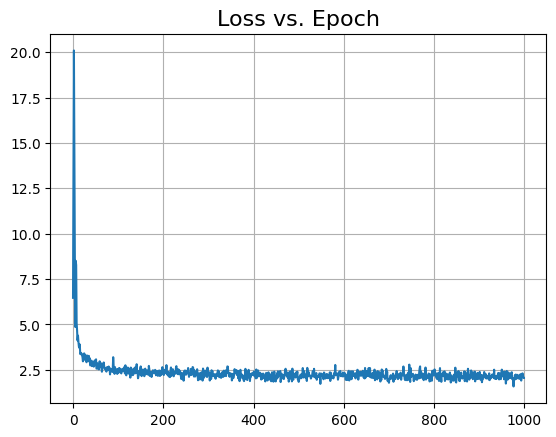

In [76]:
plt.plot(losses)
plt.title('Loss vs. Epoch', fontsize=16)
plt.grid(True)
plt.show()

Traning loss

In [77]:
print("Traning loss: ",losses[-1].item())

Traning loss:  2.0533437728881836


Validation loss

In [78]:
emb = tf.gather(C,Xdev) # [batch, block_size, embedding_dim]
h1 = tf.keras.activations.gelu((tf.reshape(emb , shape=(-1 , n_emb*context_len)) @ W1) + b1)
h2 = tf.keras.activations.gelu(h1 @ W2 + b2)
h3 = tf.keras.activations.gelu(h2 @ W3 + b3)
logits = h3 @ W4 + b4
loss = loss_fn(tf.reshape(Ydev, [-1]), logits)
print("Validation loss: ",loss.numpy().item())

Validation loss:  2.1357202529907227


Sampling newly generated names

In [79]:
block_size = 8
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = tf.gather(C , tf.constant([context] , dtype=tf.int32)) # (1,block_size,d)
      emb_flat = tf.reshape(emb, [1, -1])
      h1 = tf.keras.activations.gelu(tf.matmul(emb_flat, W1) + b1)
      h2 = tf.keras.activations.gelu(tf.matmul(h1, W2) + b2)
      h3 = tf.keras.activations.gelu(tf.matmul(h2, W3) + b3)
      logits = tf.matmul(h3, W4) + b4 # (B,block_size,vocab_size)
      probs = tf.nn.softmax(logits, axis=1)
      ix = tf.random.categorical(tf.math.log(probs), num_samples=1)[0, 0].numpy()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(idx_to_str[i] for i in out))

Mathiro_Tohugi.
Ring_Satsutou_Makiki.
Kyuugi_Hihukazuji.
Keioro_Kaiki.
Ctetar_Munki.
Nat_Sukougika.
Kizuki_Gito.
Miitgi_Yuchi.
Mamo_Delan.
Piogamare.
Sakami_Homishige_Afalere.
Ji.
He_Haanami.
Ikie_Touzuwa.
Cessa_Hiddou.
Chau_Yuukumasaki.
Purnga.
Ranchi_Abela.
Kagisaki.
Auio_Gikika.


Saving the trained weights

In [80]:
checkpoint = tf.train.Checkpoint(
    C = C , W1 = W1 , b1 = b1 , W2 = W2 , b2 = b2 , W3 = W3 , b3 = b3 , W4 = W4 , b4 = b4
)

save_path = checkpoint.save("./checkpoints/anime_model")
print(f"Model saved at: {save_path}")

Model saved at: ./checkpoints/anime_model-1


For restoring the saved weights

In [ ]:
# checkpoint = tf.train.Checkpoint(
#     C=C, W1=W1, b1=b1, W2=W2, b2=b2, W3=W3, b3=b3
# )

# checkpoint.restore(tf.train.latest_checkpoint("./checkpoints")).expect_partial()
# print("Model restored from latest checkpoint!")

### Batch Normalization

In [81]:
tf.keras.backend.clear_session()

In [82]:
momentum = 0.99

In [83]:
gamma_1 = tf.Variable(tf.ones(shape=(n_neurons_l1,)))
beta_1 = tf.Variable(tf.zeros(shape=(n_neurons_l1,)))

gamma_2 = tf.Variable(tf.ones(shape=(n_neurons_l2,)))
beta_2 = tf.Variable(tf.zeros(shape=(n_neurons_l2,)))

gamma_3 = tf.Variable(tf.ones(shape=(n_neurons_l3,)))
beta_3 = tf.Variable(tf.zeros(shape=(n_neurons_l3,)))

In [84]:
# BatchNorm1
running_mean_01 = tf.Variable(tf.zeros([1, n_neurons_l1]), trainable=False)
running_std_01 = tf.Variable(tf.ones([1, n_neurons_l1]), trainable=False)

# BatchNorm2
running_mean_02 = tf.Variable(tf.zeros([1, n_neurons_l2]), trainable=False)
running_std_02 = tf.Variable(tf.ones([1, n_neurons_l2]), trainable=False)

#BatchNorm3
running_mean_03 = tf.Variable(tf.zeros([1, n_neurons_l3]), trainable=False)
running_std_03 = tf.Variable(tf.ones([1, n_neurons_l3]), trainable=False)

In [85]:
seed = tf.random.set_seed(424242424)
initializer = tf.keras.initializers.HeNormal(seed=seed)

C = tf.Variable(tf.random.uniform(shape=(vocab_size , n_emb) , seed = seed))

W1 = tf.Variable(initializer(shape=(n_emb*context_len , n_neurons_l1)))
b1 = tf.Variable(tf.random.uniform(shape=[n_neurons_l1]))

W2 = tf.Variable(initializer(shape=(n_neurons_l1 , n_neurons_l2)))
b2 = tf.Variable(tf.random.uniform(shape = [n_neurons_l2]))

W3 = tf.Variable(initializer(shape=(n_neurons_l2 , n_neurons_l3)))
b3 = tf.Variable(tf.random.uniform(shape = [n_neurons_l3]))

W4 = tf.Variable(initializer(shape=(n_neurons_l3 , vocab_size)))
b4 = tf.Variable(tf.random.uniform(shape = [vocab_size]))


**0.34M PARAMETERS DNN MODEL WITH BATCH NORM**

In [87]:
parameters = [C , W1 , b1 , W2 , b2 , W3 , b3 , W4 , b4 , gamma_1 , beta_1 , gamma_2 , beta_2 , gamma_3 , beta_3]
no_params = 0
for p in parameters:
  no_params += tf.size(p).numpy()

print('Total number of parameters: ', no_params.item())

Total number of parameters:  341017


In [88]:
num_epochs = 1000
learning_rate = 0.01
losses = []
batch_size = 64

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

for epoch in range(num_epochs):
    ix = tf.keras.random.randint(shape = (batch_size,) , minval=0 , maxval=Xtr.shape[0] , seed = seed)
    Xb, Yb = tf.gather(Xtr , ix) , tf.gather(Ytr , ix) # batch X,Y

    with tf.GradientTape() as tape:
        # Embedding and reshape
        emb = tf.gather(C, Xb)  # [batch, block_size, embedding_dim]
        x1 = tf.reshape(emb, shape=(-1, n_emb * context_len))

        # Layer 1 linear transformation
        x1 = x1 @ W1 + b1

        # BatchNorm1
        mean1 = tf.reduce_mean(x1, axis=0, keepdims=True)
        std1 = tf.math.reduce_std(x1, axis=0, keepdims=True)
        x1 = (x1 - mean1) / tf.sqrt(std1 + 1e-5)
        x1 = x1 * gamma_1 + beta_1

        # Activation
        h1 = tf.keras.activations.gelu(x1)

        # Layer 2
        x2 = h1 @ W2 + b2

        # BatchNorm2
        mean2 = tf.reduce_mean(x2, axis=0, keepdims=True)
        std2 = tf.math.reduce_std(x2, axis=0, keepdims=True)
        x2 = (x2 - mean2) / tf.sqrt(std2 + 1e-5)
        x2 = x2 * gamma_2 + beta_2

        # Activation
        h2 = tf.keras.activations.gelu(x2)

        # Layer 3
        x3 = h2 @ W3 + b3

        # BatchNorm 3
        mean3 = tf.reduce_mean(x3, axis=0, keepdims=True)
        std3 = tf.math.reduce_std(x3, axis=0, keepdims=True)
        x3 = (x3 - mean3) / tf.sqrt(std3 + 1e-5)
        x3 = x3 * gamma_3 + beta_3

        # Activation
        h3 = tf.keras.activations.gelu(x3)

        # Output layer
        logits = h3 @ W4 + b4

        # Loss
        loss = loss_fn(tf.reshape(Yb, [-1]), logits)

    # ✅ Update running statistics (outside the tape)
    running_mean_01.assign(momentum * running_mean_01 + (1. - momentum) * mean1)
    running_std_01.assign(momentum * running_std_01 + (1. - momentum) * std1)
    running_mean_02.assign(momentum * running_mean_02 + (1. - momentum) * mean2)
    running_std_02.assign(momentum * running_std_02 + (1. - momentum) * std2)
    running_mean_03.assign(momentum * running_mean_03 + (1. - momentum) * mean3)
    running_std_03.assign(momentum * running_std_03 + (1. - momentum) * std3)

    # Backprop
    grads = tape.gradient(loss, parameters)
    optimizer.apply_gradients(zip(grads, parameters))

    losses.append(loss.numpy())

    if epoch % 25 == 0:
        print(f"epoch={epoch}, loss={loss.numpy():.4f}")


epoch=0, loss=4.3159
epoch=25, loss=2.6757
epoch=50, loss=2.3487
epoch=75, loss=2.6010
epoch=100, loss=2.5780
epoch=125, loss=2.2573
epoch=150, loss=2.3253
epoch=175, loss=2.2094
epoch=200, loss=2.2316
epoch=225, loss=2.5071
epoch=250, loss=2.0741
epoch=275, loss=2.0198
epoch=300, loss=2.1674
epoch=325, loss=2.2061
epoch=350, loss=2.1732
epoch=375, loss=2.5019
epoch=400, loss=2.0486
epoch=425, loss=1.8641
epoch=450, loss=2.0870
epoch=475, loss=1.9889
epoch=500, loss=2.1891
epoch=525, loss=2.2635
epoch=550, loss=2.0521
epoch=575, loss=2.0351
epoch=600, loss=2.3895
epoch=625, loss=2.3028
epoch=650, loss=2.2299
epoch=675, loss=1.9998
epoch=700, loss=2.3187
epoch=725, loss=2.3496
epoch=750, loss=2.3955
epoch=775, loss=2.1874
epoch=800, loss=2.0588
epoch=825, loss=1.9509
epoch=850, loss=2.4040
epoch=875, loss=1.8999
epoch=900, loss=2.1999
epoch=925, loss=1.9996
epoch=950, loss=2.4219
epoch=975, loss=1.9678


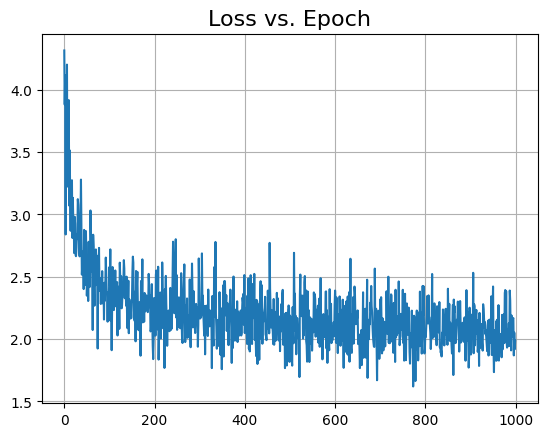

In [89]:
plt.plot(losses)
plt.title('Loss vs. Epoch', fontsize=16)
plt.grid(True)
plt.show()

In [90]:
print("Traning loss: ",losses[-1].item())

Traning loss:  1.991283655166626


In [91]:
emb = tf.gather(C,Xdev) # [batch, block_size, embedding_dim]
x1 = tf.reshape(emb, shape=(-1, n_emb * context_len))
x1 = x1 @ W1 + b1
x1 = (x1 - running_mean_01) / tf.sqrt(running_std_01 + 1e-5)
x1 = x1 * gamma_1 + beta_1
h1 = tf.keras.activations.gelu(x1)

x2 = h1 @ W2 + b2
x2 = (x2 - running_mean_02) / tf.sqrt(running_std_02 + 1e-5)
x2 = x2 * gamma_2 + beta_2
h2 = tf.keras.activations.gelu(x2)

x3 = h2 @ W3 + b3
x3 = (x3 - running_mean_03) / tf.sqrt(running_std_03 + 1e-5)
x3 = x3 * gamma_3 + beta_3
h3 = tf.keras.activations.gelu(x3)

logits = h3 @ W4 + b4
loss = loss_fn(tf.reshape(Ydev, [-1]), logits)
print("Validation loss: ",loss.numpy().item())

Validation loss:  2.0813345909118652
